In [ ]:
!pip install face-recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=93fe826358d2b9518b8cab086410fb068b081fb01dd929a698f3074c9eb65880
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models


In [ ]:
import tensorflow as tf
import cv2
import face_recognition
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


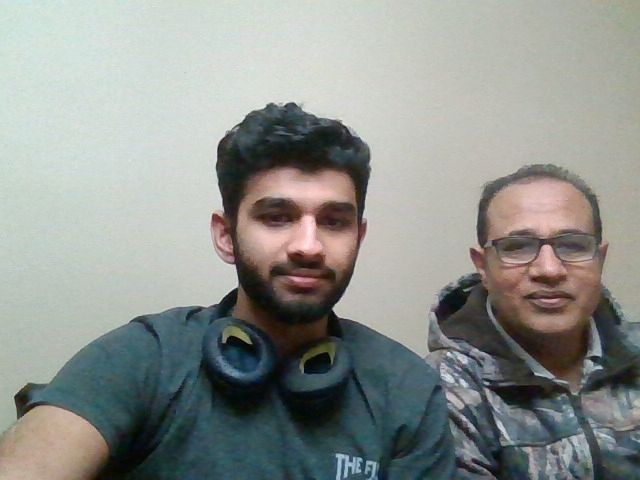

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ANN_Project/Models/FMClassifier_B')

1/1 [==============================] - 2s 2s/step
[[0. 1.]
 [0. 1.]]


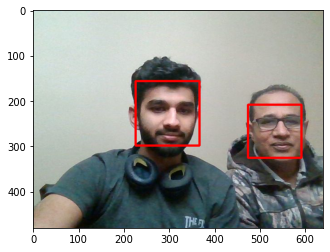

In [ ]:
# Find all the faces and face enqcodings in the frame of video
frame = face_recognition.load_image_file(filename)
detected_faces = []
face_locations = face_recognition.face_locations(frame, model='cnn')
if(len(face_locations) != 0):
  # Loop through each face in this frame of video
  for(top, right, bottom, left) in face_locations:
    #get the face from the image
    face = frame[top:bottom, left:right]
    #resize the face
    face = cv2.resize(face, (100, 100))
    detected_faces.append(face)

  y_pred = model.predict(np.array(detected_faces))
  print(y_pred)

  for(top, right, bottom, left),pred in zip(face_locations, y_pred):
    if(pred[0] > 0.5):
      cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3) #green if mask
    elif(pred[1] > 0.5):
      cv2.rectangle(frame, (left, top), (right, bottom), (255, 0, 0), 3) #red if no mask
    else:
      cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 3) #blue if none

# Display the resulting image
plt.imshow(frame)